In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn import svm

import sys
sys.path.append('../')
from src.ga import GeneticAlgorithm

In [7]:
senvol = pd.read_csv('../data/interim/senvol.csv')
senvol.head()

,Unnamed: 0,,Material Supplier,Material Name,AM Process,General Material Type,Specific Material Type,Post Processed,Ultimate Tensile Strength Min (MPa),Ultimate Tensile Strength Max (MPa),...,Hardness Min,Hardness Max,HDT Min (C),HDT Max (C),Glass Transition Temp Min (C),Glass Transition Temp Max (C),Part Density (g/cm3),Flammability,USP Class VI Certified,Availability
0,0,Click for Details,3D Platform,3DP ABS,Material Extrusion,Polymer,ABS,No,,,...,,,,,,,,,,
1,1,Click for Details,3D Platform,3DP ABS-X,Material Extrusion,Polymer,ABS,No,,,...,,,,,,,,,,
2,2,Click for Details,3D Platform,3DP FLEX 45,Material Extrusion,Polymer,Rubber-like,No,24,24,...,,,,,,,,,,
3,3,Click for Details,3D Platform,3DP HIPS,Material Extrusion,Polymer,HIPS,No,22,22,...,,,,,,,,,,
4,4,Click for Details,3D Platform,3DP PET-G,Material Extrusion,Polymer,PETG,No,,,...,,,,,,,,,,


In [12]:
senvol.columns

Index(['Unnamed: 0', ' ', 'Material Supplier', 'Material Name', 'AM Process',
       'General Material Type', 'Specific Material Type', 'Post Processed',
       'Ultimate Tensile Strength Min (MPa)',
       'Ultimate Tensile Strength Max (MPa)', 'Tensile Modulus Min (MPa)',
       'Tensile Modulus Max (MPa)', 'Elongation at Break Min (%)',
       'Elongation at Break Max (%)', 'Flexural Strength Min (MPa)',
       'Flexural Strength Max (MPa)', 'Flexural Modulus Min (MPa)',
       'Flexural Modulus Max (MPa)', 'Hardness Shore Scale', 'Hardness Min',
       'Hardness Max', 'HDT Min (C)', 'HDT Max (C)',
       'Glass Transition Temp Min (C)', 'Glass Transition Temp Max (C)',
       'Part Density (g/cm3)', 'Flammability', 'USP Class VI Certified',
       'Availability'],
      dtype='object')

In [23]:
senvol['Post Processed'].value_counts()

No     3061
Yes     765
Name: Post Processed, dtype: int64

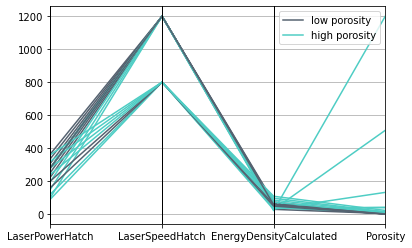

In [190]:
scale_porosity = MinMaxScaler(feature_range=(0,1200))
param_data.Porosity = scale_porosity.fit_transform(param_data.Porosity.values.reshape(-1,1))
cols = ['LaserPowerHatch', 'LaserSpeedHatch', 'EnergyDensityCalculated', 'Porosity']
param_data['level']  = pd.qcut(param_data.Porosity, q=[0, 0.5, 1.0], labels =['low porosity','high porosity'])
pd.plotting.parallel_coordinates(param_data, class_column='level', cols=cols, color=('#556270', '#4ECDC4', '#C7F464'))
plt.show()

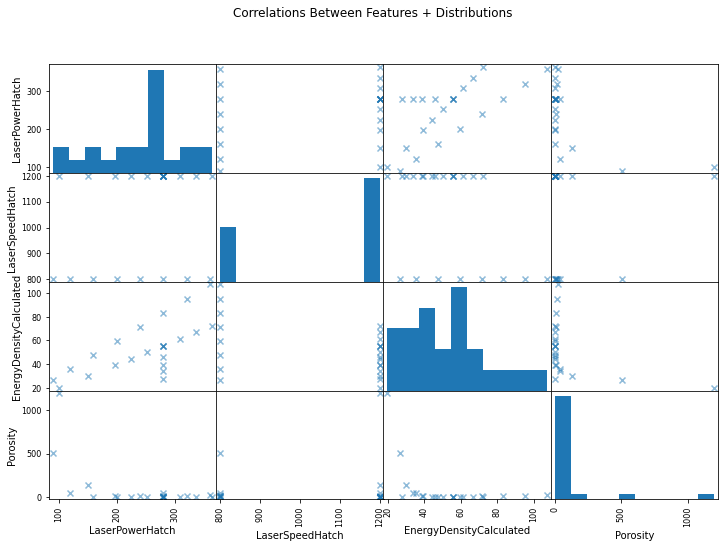

In [191]:
pd.plotting.scatter_matrix(param_data[cols], marker='x',figsize=(12,8))
plt.suptitle('Correlations Between Features + Distributions')
plt.show()

In [192]:
features = ["LaserPowerHatch","LaserSpeedHatch","Porosity"]
for col in param_data.columns:
    try:
        # dropping unnecessary columns, put into error catching so the program doesn't quit if one of these are already dropped or doesnt exist
        if col not in features:
            param_data = param_data.drop(col, axis=1)
            print(f"dropped {col}")
    except:
        print(f"already dropped {col}")
try:
    # dropping outliers
    param_data = param_data.drop([10,14,9], axis=0).reset_index(drop=True)
except:
    print('already dropped outliers')
# reorder to put label (Porosity) to make label selection easy (can index last column with [:,-1])
param_data = param_data[features]

dropped ID
dropped StudySample
dropped HatchSpacing
dropped LaserPowerContour
dropped LayerHeight
dropped EnergyDensityCalculated
dropped Machine
dropped Powder
dropped MicroCTScan
dropped HatchOffsetFromCountour
dropped level


In [193]:
# test train split, random sampling, train/test exports - can be left alone
tt_split = .25
pct = 1 - tt_split
seed = 200

train_data = param_data.sample(frac=pct, random_state=seed).reset_index(drop=True)
test_data = param_data.drop(train_data.index).sample(frac=1, random_state=seed).reset_index(drop=True)

In [241]:
def feature_label_join(X, y):
    df = pd.DataFrame(np.concatenate([X,y], axis=1))
    return df

def transform(train_data, test_data, scale_X, scale_y):
    train_vals = train_data.values
    test_vals = test_data.values

    X_train = scale_X.fit_transform(train_vals[:,:-1])
    y_train = scale_y.fit_transform(train_vals[:,-1].reshape(-1, 1))

    X_test = scale_X.transform(test_vals[:,:-1])
    y_test = scale_y.transform(test_vals[:,-1].reshape(-1, 1))

    train = feature_label_join(X_train, y_train)
    test = feature_label_join(X_test, y_test)

    return train, test, scale_X, scale_y

train, test, sx, sy = transform(train_data, test_data, MinMaxScaler(), StandardScaler())

In [230]:
X = train.values[:,:-1]
y = train.values[:,-1]
X_test = test.values[:,:-1]
y_test = test.values[:,-1]
svr = svm.SVR(kernel='poly', degree=2)
svr.fit(X, y)
mlp_regressor = MLPRegressor(hidden_layer_sizes=(5), alpha=.1, activation='tanh', solver='lbfgs')
mlp_regressor.fit(X, y)

print('svr score:', svr.score(X_test, y_test))
print('mlp score:', mlp_regressor.score(X_test, y_test))

svr score: 0.9631714113533093
mlp score: 0.7666268534668489


In [246]:
ga = GeneticAlgorithm(svr, sx, sy, ['LaserSpeedHatch', 'LaserPowerHatch'], [(100,400), (600,1200)], pop_size=50)
best = ga.run(mode='minimize', select='rank', mutation_rate='dynamic', exploration=.2, generations=500)

In [249]:
ga.model_predict(best)

0.5975348249596815